# Reinforcement Learning Notebook

## AER1516 Final Project, Spring 2023

This notebook contains code to pre-train the project's RL model in a mock environment ("simulation of a simulation"). The goal is to create a simple RL agent which learns to navigate while avoiding regions of high uncertainty.

RL training code is based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
# https://github.com/Farama-Foundation/Gymnasium
%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\EvanC\Documents\ML\jupyenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
# For saving gifs
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\EvanC\Documents\ML\jupyenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
####################################################################################################
# Imports, config, and utils
####################################################################################################

import gymnasium as gym
import math
import random
from datetime import datetime
from time import sleep
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
import pickle as pk
import imageio
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Project dependency
import replay_memory

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

SOGM_DIM = 95
SHOW_BREADCRUMBS = True
SAVE_FRAMES = True
SEED = 1337

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Util for measuring time intervals. To profile, measure start and end time using time.now()
time = datetime.utcnow()
def delta_t(a, b):
    return abs(a-b).total_seconds()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">> Device =", device)

>> Device = cuda


C:\Users\EvanC\Documents\ML\jupyenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll leverage Farama foundation's Gymnasium library (formerly OpenAI's Gym) for connecting our RL model to an envorinment it can interact with and learn from. Specifically, we define `MockEnv` class for pretraining with synthetic data.

Useful links:
 - Core Env class: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/core.py#L21
 - Blog post on creating a gym env: https://blog.paperspace.com/creating-custom-environments-openai-gym/

## Helpers and Environment Definitions

In [ ]:
# Utility for making 2D Gaussian blur kernels
def make_blur_kernel(kernel_size, sigma):
    # Create 2D convolution object
    conv = nn.Conv2d(1, 1, kernel_size, padding = kernel_size // 2, bias=False)

    # Generate kernel values
    kernel = torch.zeros(kernel_size, kernel_size)
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - (kernel_size // 2), j - (kernel_size // 2)
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    kernel = kernel / (2 * np.pi * sigma ** 2)

    # Normalize and return the 2D convolution object
    conv.weight.data[0, 0] = kernel / kernel.sum()
    return conv

# Utility for applying a convolution kernel to a 2D, unbatched input tensor
def apply_kernel(input, kernel):
    dim = list(input.size())
    with torch.no_grad():
        # Unsqueeze and squeeze *twice* to add a channel and batch dimension
        output = kernel(input.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)[0:dim[0], 0:dim[1]]
    return output

# Utility for drawing centered, circular masks in 2D tensors
def circle_mask(size, radius):
    x, y = torch.meshgrid(torch.arange(size), torch.arange(size))
    return ((x - size//2)**2 + (y - size//2)**2 <= radius**2).float()

# Utility for normalizing SOGMs to have a maximum value of 1.0
def normalize_sogm(sogm):
    if sogm.max() > 1e-4:
        sogm = sogm / sogm.max()
    return sogm

# Simpler helper for rotating 2D cartesian coordinates
def rotate(x, y, theta):
    x_ = x * np.cos(theta) - y * np.sin(theta)
    y_ = x * np.sin(theta) + y * np.cos(theta)
    return x_, y_


In [ ]:
####################################################################################################
# Environment classes
####################################################################################################

class MockAgent():
    def __init__(self, x, y, theta, v=1.0):
        self.x = x # m
        self.y = y # m
        self.theta = theta # rad
        self.v = v # m/s

    def tick(self, dt):
        self.x += dt * self.v * np.cos(self.theta)
        self.y += dt * self.v * np.sin(self.theta)

class MockEnv(gym.Env):
    """
    Premise: a 2D, top-down view of a large arena filled with a handful of point
      obstacles randomly moving in straight lines. The agent starts in the middle of 
      the arena and drives for a fixed amount of time. The agent can:
      - veer left       (action = 0)
      - remain straight (action = 1)
      - veer right      (action = 2)
      
      Note: collisions between the agent and obstacles are not considered.
      
      The observed state space is a blurred "heatmap" of the occupancy grid plus
      a short projection of future motion. A close radius around the agent is
      blurred a larger amount, indicating greater uncertainty when the agent is
      within interaction distance of obstacles.

      The reward is a combination of:
      - A turning penalty, creating a preference for driving straight
      - The negative sum of the entropy of all occupancy grid elements.
      
      Together, these will reward the agent for driving straight while avoiding highly uncertain regions.
    """
    def __init__(self):
        super(MockEnv, self).__init__()

        # Action space:
        self.action_space = gym.spaces.Discrete(3,) # left, straight, right

        self.arena_dim = 30      # Meters
        self.pixel_size = 0.12   # Each pixel is this many meters
        self.obstacle_count = 10
        self.obstacles = [None]*self.obstacle_count
        self.time = 0.0          # Seconds
        self.frame_index = 0
        self.delta_t = 0.5       # Seconds
        self.agent_history = []

        # Define a Gaussian kernel for blurring the map
        self.blur_conv = make_blur_kernel(12, 3.0)

        # Create two blurred masks for adjusting how the environment is perceived and reward is calculated
        self.proximity_mask = circle_mask(SOGM_DIM, 10.0)
        self.proximity_mask = apply_kernel(self.proximity_mask, self.blur_conv)

        # Wrap up!
        self.reset()
        return


    # Helper utility for drawing single pixels onto the SOGM with handrolled antialiasing.
    # Input: sogm - 2D SOGM tensor image
    #        x, y - pixel coordinate in meters. 
    # Note: 0,0 is drawn to the center of the SOGM, with +x = up, and +y = left.
    def render_point(self, sogm, x, y, alpha=1.0):
        x_ = (-x / self.pixel_size) + math.floor(SOGM_DIM/2)
        y_ = (-y / self.pixel_size) + math.floor(SOGM_DIM/2)
        i = math.floor(y_) # Columns
        j = math.floor(x_) # Rows
        dx, dy = x_ - j, y_ - i
        
        if i > 0 and i < SOGM_DIM-1:
          if j > 0 and j < SOGM_DIM-1:
            # Fill the nearest four pixels with anti-aliasing
            sogm[j, i]     += (1 - dx) * (1 - dy) * alpha
            sogm[j+1, i]   += dx * (1 - dy) * alpha
            sogm[j, i+1]   += (1 - dx) * dy * alpha
            sogm[j+1, i+1] += dx * dy * alpha
        return


    # Helper utility for drawing single pixels onto the SOGM by taking the max of the SOGM and new pixel values
    # Input: sogm - 2D SOGM tensor image
    #        x, y - pixel coordinate in meters
    # Note: 0,0 is drawn to the center of the SOGM, with +x = up, and +y = left.
    def render_point_max(self, canvas, x, y, alpha=1.0):
        x_ = (-x / self.pixel_size) + math.floor(SOGM_DIM/2)
        y_ = (-y / self.pixel_size) + math.floor(SOGM_DIM/2)
        i = math.floor(y_) # Columns
        j = math.floor(x_) # Rows
        dx, dy = x_ - j, y_ - i

        if i > 0 and i < SOGM_DIM-1:
          if j > 0 and j < SOGM_DIM-1:
            # Fill the nearest four pixels with anti-aliasing
            canvas[j, i]     = max((1 - dx) * (1 - dy) * alpha, canvas[j, i])
            canvas[j+1, i]   = max(dx * (1 - dy) * alpha, canvas[j+1, i])
            canvas[j, i+1]   = max((1 - dx) * dy * alpha, canvas[j, i+1])
            canvas[j+1, i+1] = max(dx * dy * alpha, canvas[j+1, i+1])
        return
    

    # Render an obstacle's SOGM for a single point prediction.
    # Note: Full SOGMs are a composite of multiple point predictions along a trajectory.
    def draw_obstacle_sogm(self, x, y, alpha):
        # Render a point and apply Gaussian blur
        output = torch.zeros(SOGM_DIM, SOGM_DIM, requires_grad=False)
        self.render_point(output, x, y, alpha)
        output = apply_kernel(output, self.blur_conv)

        # Normalize visible SOGMs
        output = normalize_sogm(output)

        # Floor and apply alpha
        mask = (output >= (200./255.))
        output = alpha * output * mask

        return output


    def draw_sogm(self):
        sogm = torch.zeros(SOGM_DIM, SOGM_DIM, requires_grad=False)

        # Render obstaces
        for obstacle in self.obstacles:
            # Project obstacle's motion into the future
            time_horizon = 1.5 # Seconds
            for t in np.linspace(0.0, time_horizon, math.ceil(time_horizon * obstacle.v / self.pixel_size)):
                obstacle_future_x = obstacle.x + obstacle.v * t * np.cos(obstacle.theta)
                obstacle_future_y = obstacle.y + obstacle.v * t * np.sin(obstacle.theta)
                dx, dy = rotate(obstacle_future_x - self.agent.x, \
                                obstacle_future_y - self.agent.y, \
                                -self.agent.theta)
                obstacle_point_sogm = self.draw_obstacle_sogm(dx, dy, alpha = 1. - t/time_horizon)
                sogm = torch.maximum(sogm, obstacle_point_sogm)

        # Blur the SOGM in the center region, causing a sharp increase in uncertainty close to obstacles
        close_sogm = self.proximity_mask * sogm
        sogm_blurred = 0.5 * torch.ones_like(sogm) * close_sogm.max()
        sogm = sogm_blurred * self.proximity_mask + \
               sogm * (1.0 - self.proximity_mask)

        # Normalize the image
        sogm = normalize_sogm(sogm)

        return sogm


    # Execute one time step within the environment
    def step(self, action):
        self.time += self.delta_t
        self.frame_index += 1
        
        # Assert that the given action is valid
        assert self.action_space.contains(action), "Invalid Action"

        if action == 0:
          # LEFT
          self.agent.theta += np.pi/10.0 # 18 degrees
        elif action == 1:
          # STRAIGHT
          pass
        elif action == 2:
          # RIGHT
          self.agent.theta -= np.pi/10.0 # 18 degrees

        self.agent.tick(self.delta_t)
        self.agent_history.append((self.agent.x, self.agent.y))
        
        for obstacle in self.obstacles:
            obstacle.tick(self.delta_t)
  
        observation = self.draw_sogm()

        # Calculate the reward as the entropy of a distance-weighted, normalized view of the observation
        eps = 1e-3 # Small value for numerical stability
        probability_field = (1. - 2 * eps) * observation + eps

        # Reward is sum of the negative entropy of all pixels
        reward = torch.sum(probability_field * torch.log(probability_field) +
                          (1. - probability_field) * torch.log(1. - probability_field))
        
        # Add reward term to penalize turning
        if action != 1:
            reward -= 100.0
        
        terminated = (self.time > 15.0) 
        truncated = False
        info = None
        return observation, reward, terminated, truncated, info 


    # Reset the state of the environment to an initial state
    def reset(self):
        self.time = 0.0
        self.frame_index = 0
        
        # Start our agent in the center of the arena, theta=0 (moving right across arena)
        self.agent = MockAgent(self.arena_dim/2.0, self.arena_dim/2.0, 0.0)
        self.agent.v = 1.0
        self.agent_history = [(self.agent.x, self.agent.y)]
        
        # Populate random obstacles within the arena.
        x_offset = self.arena_dim * 0.25
        self.obstacles = [MockAgent(random.uniform(0.0, self.arena_dim),
                                    random.uniform(0.0, self.arena_dim),
                                    random.uniform(0.0, 2*np.pi),
                                    random.uniform(0.0, 1.2)) for i in range(self.obstacle_count)]
        
        # Re-init obstacles close to the agent. Repeat 10 times to make overlap statistically improbable.
        for i in range(10):
          for obstacle in self.obstacles:
              if np.hypot(obstacle.x-self.agent.x, obstacle.y-self.agent.y) < 3.0:
                  obstacle.x, obstacle.y = random.uniform(0.0, self.arena_dim), random.uniform(0.0, self.arena_dim)

        observation = self.draw_sogm()
        return observation, None


    # Render the environment to the screen
    def render(self, mode='human', close=False):
        sogm = self.draw_sogm()

        # Draw the agent history
        if SHOW_BREADCRUMBS:
            for (x, y) in self.agent_history:
                dx, dy = rotate(x - self.agent.x, \
                                y - self.agent.y, \
                                -self.agent.theta)
                self.render_point_max(sogm, dx, dy, alpha = 1.0)

        plt.imshow(sogm, cmap='gray')
        
        # Save animation frames to make a gif later
        if SAVE_FRAMES:
            plt.imsave("sogm_{}.png".format(self.frame_index), sogm, cmap='gray')
        plt.show()
        return


    def close(self):
        # Tear down and clean up
        pass

## Visualizing our Mock Environment

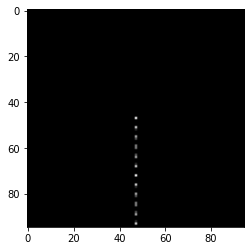

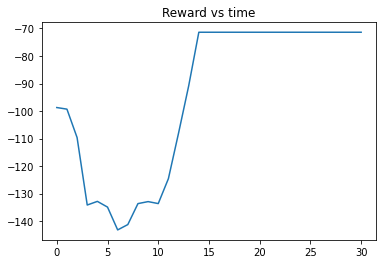

<terminated>
Simulation complete!


In [ ]:
# Run the environment for a few seconds!
env = MockEnv()

rewards = []

for i in range(1000):
    action = 1 # Go straight.
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
   
    plt.pause(0.02)
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Render the environment
    env.render()
    
    plt.title("Reward vs time")
    plt.plot(rewards)
    plt.show()
        
    if terminated or truncated:
        print("<terminated>")
        break
        
print("Simulation complete!")

## Model Definition

In [ ]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, input_size=95, n_actions=3):
        super(DQN, self).__init__()
        self.inner_dim = 32 * 6 * 6 # Depends on input size
        self.pre_pool = nn.MaxPool2d(kernel_size=3)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(self.inner_dim, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def forward(self, x):
        # Add a channel dimension so we can put our [BATCH, DIM, DIM] 2D map through a convnet
        x = x.unsqueeze(1)
        # x.size() = torch.Size([B, 1, 95, 95])
        x = self.pre_pool(x)
        # x.size() = torch.Size([1, 1, 31, 31])
        x = self.conv1(x)
        x = self.pool1(x)
        x = torch.relu(x)
        # x.size() = torch.Size([1, 16, 14, 14])
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        # x.size() = torch.Size([1, 32, 6, 6])
        x = x.view(-1, self.inner_dim)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## RL Training Code

In [ ]:
env = MockEnv()

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer

BATCH_SIZE = 50
GAMMA = 0.977
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 300
TAU = 0.01
LR = 1e-3

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()

policy_net = DQN(SOGM_DIM, n_actions).to(device)
target_net = DQN(SOGM_DIM, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = replay_memory.ReplayMemory(500)
pk.dump(memory, open("memory_bank.pkl", "wb"))

steps_done = 0
episode_rewards = []

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            network_output = policy_net(state)
            action = network_output.max(1)[1].view(1, 1)
    else:
        action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    return action


def plot_rewards(show_result=False):

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

    plt.figure(1)
    rewards = torch.tensor(episode_rewards, dtype=torch.float)
    rewards_filtered = rewards.clone().detach()

    alpha = 0.1
    for i in range(1, rewards_filtered.size()[0]):
      rewards_filtered[i] = rewards_filtered[i] * alpha + rewards_filtered[i-1] * (1.-alpha)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(rewards.numpy(), label='Raw')
    plt.plot(rewards_filtered.numpy(), c='orange', label='Filtered')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def optimize_model():
    # Fill up our memory bank first before optimizing on batches
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = replay_memory.Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

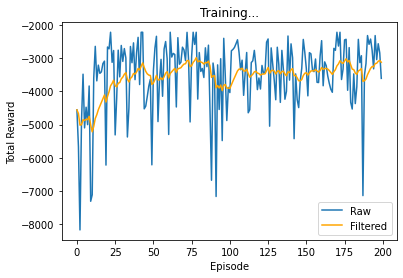

Complete


In [ ]:
num_episodes = 200

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0.0

    memory = pk.load(open("memory_bank.pkl", "rb"))
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            print("Episode {} terminated.".format(i_episode))
            episode_rewards.append(total_reward)
            plot_rewards()
            break
    pk.dump(memory, open("memory_bank.pkl", "wb"))

print('Complete')

In [ ]:
# Save network weights
torch.save(policy_net.state_dict(), "1516_policy_net_final.pt")

## Testing and Visualizing
This animates the trained agent navigating in our mock environment, and we can optionally save a gif of this.

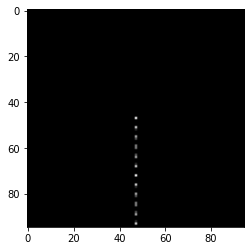

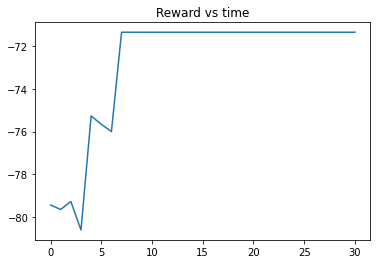

<terminated>
Simulation complete!


In [ ]:
# Run the environment with the trained agent!
env = MockEnv()
action = 1
rewards = []

for i in range(1000):
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    
    with torch.no_grad():
        network_output = policy_net(observation.unsqueeze(0).to(device))
        action = network_output.max(1)[1].view(1, 1).item()
    
    plt.pause(0.02)
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
    # Render the environment
    env.render()
    plt.title("Reward vs time")
    plt.plot(rewards)
    plt.show()

    if terminated or truncated:
        print("<terminated>")
        break
        
print("Simulation complete!")

In [ ]:
# Make a gif
if SAVE_FRAMES:
    images = []
    for i in range(1, 32):
        image_name = f"sogm_{i}.png"
        image = imageio.imread(image_name)
        images.append(image)
        os.remove(image_name)
imageio.mimsave("sogm_animation.gif", images, fps=2)

C:\Users\EvanC\AppData\Local\Temp/ipykernel_14296/2756469563.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_name)
